# Simulate a Hospital Surge / Wave

This notebook simulates a single surge / wave of cases into a hospital, and outputs a line list in the format that would be output from a typical SQL query of PAS data.

Start by Pulling in relevant libraries.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.optimize as op
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta

## Parameters of Wave

The next block of parameters determines the overall trajectory of the wave, which is assumed to be an exponentially increasing then decreasing function arising from growth then lockdown.


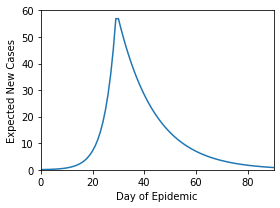

In [2]:
rr = np.log(2.0)/3.0 # Initial growth rate
rnew = -0.07 # Decline rate following successful lockdown
dlock = 30 # Day of lockdown start
dstop = 91 # Day of lockdown stop
i0 = 0.07 # Initial value of force of infection - tuned to be like a wave in a large city
mulock = i0*np.exp(rr*np.arange(0,dlock,1))
mustop = mulock[-1]*np.exp(rnew*np.arange(0,dstop-dlock,1))
mu = np.concatenate([mulock,mustop])
dayran = np.arange(0,len(mu),1)
plt.figure(figsize=(4,3))
plt.plot(dayran,mu)
plt.xlabel('Day of Epidemic')
plt.ylabel('Expected New Cases')
plt.xlim([0,90])
plt.ylim([0,60])
plt.tight_layout()

## Weibull parameters

Pick realistic (but not exactly fitted) values

In [3]:
ward2icu = np.array([0.4,-9.5])
ward2dis = np.array([0.9,-2.5])
ward2dea = np.array([1.0,-3.5])
icu2recw = np.array([1.5,-3.5])
icu2dea  = np.array([1.0,-4.5])
recw2icu = np.array([0.2,-8.0])
recw2dis = np.array([1.5,-2.0])

In [4]:
# start with a real day, then do just ward stay, then add ICU stay, and ignore covariates for now

In [5]:
dt0 = datetime.fromisoformat('2020-03-01 00:00:01')
dtend = dt0 + timedelta(days = dstop)
dtend.isoformat(' ')

'2020-05-31 00:00:01'

In [6]:
def get_scale(x):
    # Return a Weibull scale parameter from the neglog that is saved
    return np.exp(-x)

In [7]:
np.random.seed(42)

df = pd.DataFrame(columns=[
                     "NHSNumber",
                     "HospitalAdmissionTime",
                     "StartTimeCriticalCare",
                     "DischargeTimeCriticalCare",
                     "HospitalDischargeTime",
                     "DateOfDeath",
                     "BRSDays",
                     "ARSDays",
                     "DateOfBirth",
                     "Sex"])

nhsno = 0
for d in dayran:
    new_admissions = np.random.poisson(mu[d])
    for i in range(0,new_admissions):
        nhsno += 1
        
        age = 36500*np.random.random()
        dob = (dtend - timedelta(days = age)).replace(microsecond=0)
        
        dtadm = dt0 + timedelta(days=int(d), seconds = int(np.floor(24*60*60*np.random.random())))
        
        distime = get_scale(ward2dis[1])*np.random.weibull(ward2dis[0])
        disdat = (dtadm + timedelta(days = distime)).replace(microsecond=0)
        deatime = get_scale(ward2dea[1])*np.random.weibull(ward2dea[0])
        deadat = (dtadm + timedelta(days = deatime)).replace(microsecond=0)
        icutime = get_scale(ward2icu[1])*np.random.weibull(ward2icu[0])
        icudat = (dtadm + timedelta(days = icutime)).replace(microsecond=0)
        
        if ((disdat > dtend) and (deadat > dtend) and (icudat > dtend)): # Still in Acute Ward
            df = df.append({
                'NHSNumber': nhsno,
                'HospitalAdmissionTime': dtadm.isoformat(' '),
                'DateOfBirth': dob.isoformat(' '),
                },ignore_index=True)
        elif ((disdat < icudat) or (deadat < icudat)): # Does not go to ICU
            if (disdat < deadat): # Discharged from Acute Ward
                df = df.append({
                    'NHSNumber': nhsno,
                    'HospitalAdmissionTime': dtadm.isoformat(' '),
                    'HospitalDischargeTime': disdat.isoformat(' '),
                    'DateOfBirth': dob.isoformat(' '),
                    },ignore_index=True)
            else: # Died on Acute Ward
                df = df.append({
                    'NHSNumber': nhsno,
                    'HospitalAdmissionTime': dtadm.isoformat(' '),
                    'HospitalDischargeTime': deadat.isoformat(' '),
                    'DateOfDeath': deadat.isoformat(' '),
                    'DateOfBirth': dob.isoformat(' '),
                    },ignore_index=True)
        else: # Goes to ICU
            runicu = True
            ccentries = []
            ccleaves = []
            while runicu:
                if (icudat > dtend): # Still in Recovery ward from previous loop
                    runicu = False
                    deadat = np.nan
                    disdat = np.nan
                else:
                    ccentries.append(icudat)
                    recwtime = get_scale(icu2recw[1])*np.random.weibull(icu2recw[0])
                    recwdat = (icudat + timedelta(days = recwtime)).replace(microsecond=0)
                    deatime  = get_scale(icu2dea[1])*np.random.weibull(icu2dea[0])
                    deadat = (icudat + timedelta(days = deatime)).replace(microsecond=0)
                    if (deadat > dtend) and (recwdat > dtend): # Still in ICU
                        runicu = False
                        deadat = np.nan
                        disdat = np.nan
                    elif (deadat < recwdat): # Died in ICU
                        runicu = False
                        disdat = np.nan
                        ccleaves.append(deadat)
                    else: # Go to Recovery Ward
                        deadat = np.nan
                        ccleaves.append(recwdat)
                        icutime = get_scale(recw2icu[1])*np.random.weibull(recw2icu[0])
                        icudat = (recwdat + timedelta(days = icutime)).replace(microsecond=0)
                        distime = get_scale(recw2dis[1])*np.random.weibull(recw2dis[0])
                        disdat = (recwdat + timedelta(days = distime)).replace(microsecond=0)
                        if (icudat > dtend) and (disdat > dtend): # Still on Recovery
                            runicu = False
                            disdat = np.nan
                        elif (disdat < icudat): # Discharged
                            runicu = False
                        else: # A further stay on ICU
                            disdat = np.nan
            
            if pd.isna(disdat):
                distr = np.nan
            else:
                distr = disdat.isoformat(' ')
                           
            if pd.isna(deadat):
                deastr = np.nan
            else:
                deastr = deadat.isoformat(' ')
                distr = deadat.isoformat(' ')
            
            for j, icud in enumerate(ccentries):
                if ((j==(len(ccentries)-1)) and (j>=len(ccleaves))): # Last ICU entry and no leave
                    dtcc = np.nan
                else:
                    dtcc = ccleaves[j]
                df = df.append({
                    'NHSNumber': nhsno,
                    'HospitalAdmissionTime': dtadm.isoformat(' '),
                    'HospitalDischargeTime': distr,
                    'StartTimeCriticalCare': icud,
                    'DischargeTimeCriticalCare': dtcc,
                    'DateOfDeath': deastr,
                    'DateOfBirth': dob.isoformat(' '),
                    },ignore_index=True)

In [8]:
df.to_csv('./data_files/Simulated_COVID.csv')